# Evolution de la politique d'augmentation de données

Cette fois nous ferons plus attention à ne pas introduire des images du dataset de test dans le dataset d'entraînement, même si elles sont modifiées.

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import albumentations as alb

import tensorflow as tf
from tensorflow.keras import layers

import tools

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
2024-06-21 11:22:51.772485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 11:22:51.773755: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 11:22:51.817487: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 11:22:51.955125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in oth

### we can perform different type of transformations on the images

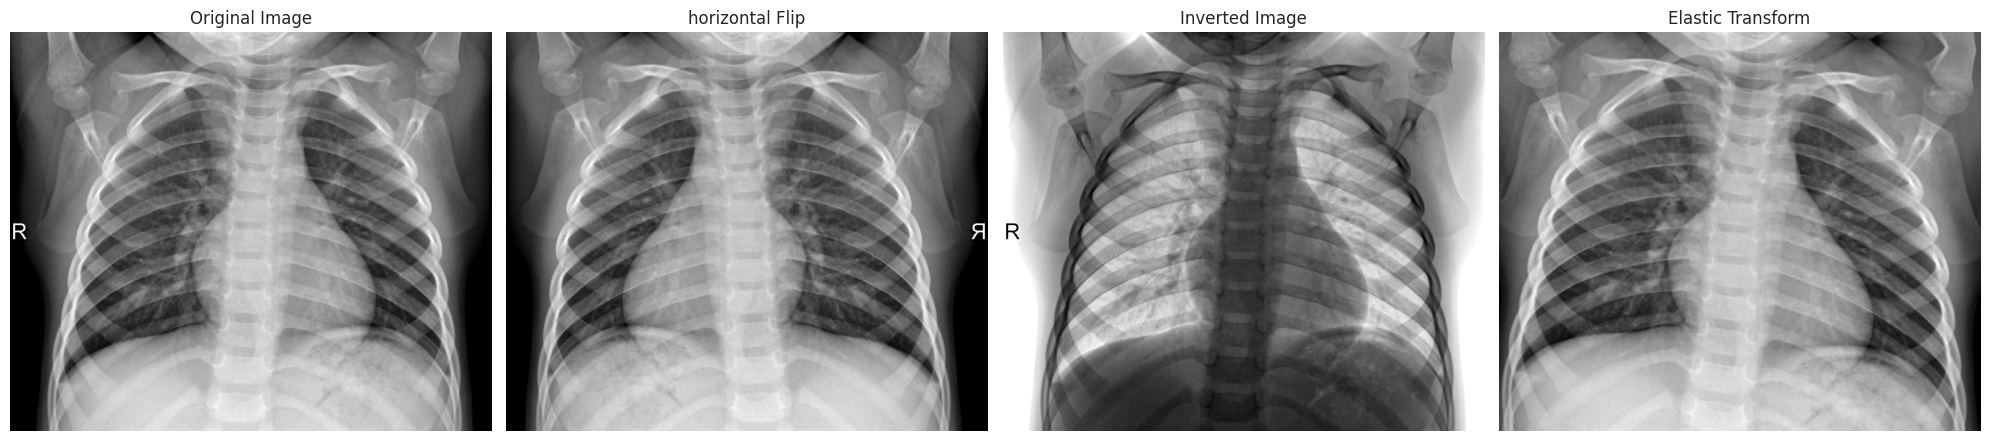

In [2]:
imgs = []
titles = []

image_path = "chest_Xray/train/NORMAL/NORMAL2-IM-0385-0001.jpeg"
imgs.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
titles.append("Original Image")

imgs.append(alb.hflip(imgs[0]))
titles.append("horizontal Flip")
imgs.append(alb.InvertImg().apply(imgs[0]))
titles.append("Inverted Image")
distortion = alb.GridDistortion(num_steps=222, distort_limit=0.95, border_mode=cv2.BORDER_CONSTANT, p=0.3)
elastic = alb.ElasticTransform(alpha=1, sigma=100, alpha_affine=100, p=0.9)
imgs.append(elastic(image=imgs[0])['image'])
titles.append("Elastic Transform")

tools.display_imgs(imgs, titles, plot_size=(4, 4), figsize=(20, 20))

### Préparation des datasets

In [3]:
original_datasetX = []
original_datasetY = []
augmented_pneumonia_datasetX = []
augmented_pneumonia_datasetY = []

test_datasetX = []
test_datasetY = []

image_size = (200, 200)
def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    original_datasetX.append(new_img)
    # replace normal with 0 and pneumonia with 1 in order to have numerical labels
    category = 0 if category == "NORMAL" else 1
    original_datasetY.append(category)

tools.browse_imgs(load_datasets)

# après avoir chargé le dataset, on met directement de coté les images de test afin d'être sûr de ne pas les modifier
original_datasetX, test_datasetX, original_datasetY, test_datasetY = train_test_split(original_datasetX, original_datasetY, test_size=0.2, random_state=1)

for i in range(0, len(original_datasetX)):
    image = original_datasetX[i]
    category = original_datasetY[i]
    transformed_img = alb.hflip(image)
    
    if category == 1:
        augmented_pneumonia_datasetX.append(transformed_img)
        augmented_pneumonia_datasetY.append(category)

# normalizing the images
original_datasetX = np.array(original_datasetX) / 255
original_datasetY = np.array(original_datasetY)
test_datasetX = np.array(test_datasetX) / 255
test_datasetY = np.array(test_datasetY)
augmented_pneumonia_datasetX = np.array(augmented_pneumonia_datasetX) / 255
augmented_pneumonia_datasetY = np.array(augmented_pneumonia_datasetY)

# la seed nous permettra de mélanger les datasets X et Y de la même manière
random_seed = 5

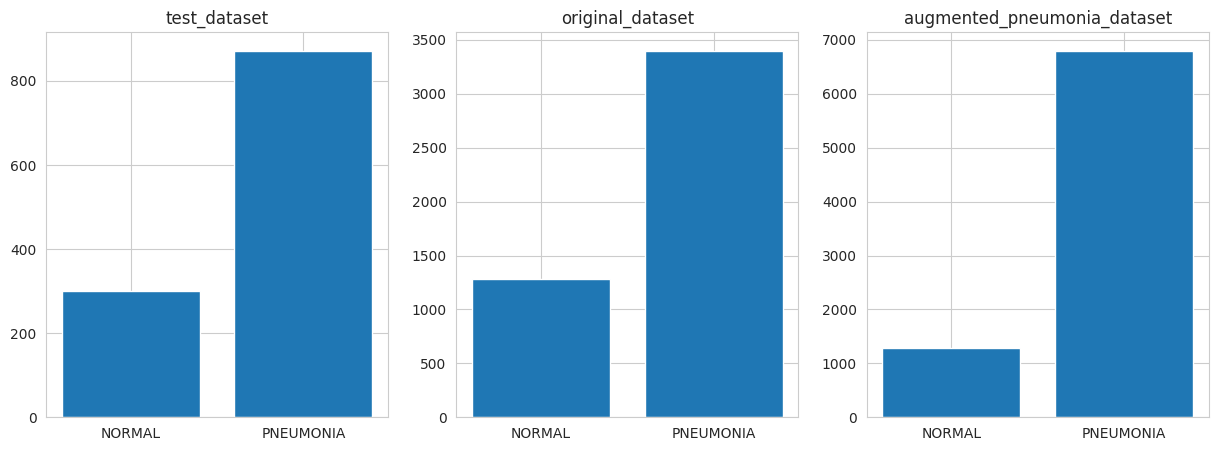

In [4]:
tools.display_distribution([test_datasetY,
                      original_datasetY,
                      np.concatenate((original_datasetY, augmented_pneumonia_datasetY))],
                     ["test_dataset", "original_dataset", "augmented_pneumonia_dataset"])

### On doit faire attention à bien tester uniquement avec des données originales pour être sûr de nos résultats

#### CNN - Convolution Neural Network

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

In [5]:
# This line sets the number of output classes for your model
num_classes = 1
# This line sets the size of the kernel to be used in the convolutional layers. The kernel is
# a small matrix that is used for blurring, sharpening, embossing, edge detection, and more
core_size = 8

# he Sequential model is a linear stack of layers that you can add to in order
model = tf.keras.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Conv2D(32, core_size, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 193, 193, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     2,949,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,951,221 (11.26 MB)

 Trainable params: 2,951,221 (11.26 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['recall'])

In [7]:
def train_and_test_with_confusion_matrix(datasetX, datasetY, epoch=2):
    xtrain, xval, ytrain, yval = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
    model.fit(xtrain,
          ytrain,
          validation_data=(xval, yval),
          epochs=epoch)
    
    y_pred = model.predict(test_datasetX)
    tools.display_confusion_matrix_and_scores(test_datasetY, y_pred)

### testing model on augmented pneumonia dataset (only pneumonia images are augmented in order to focus on pneumonia detection)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


203/203 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - loss: 0.5066 - recall: 0.9678 - val_loss: 0.1738 - val_recall: 0.9942
Epoch 2/2
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - loss: 0.1854 - recall: 0.9918 - val_loss: 0.1604 - val_recall: 0.9935
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


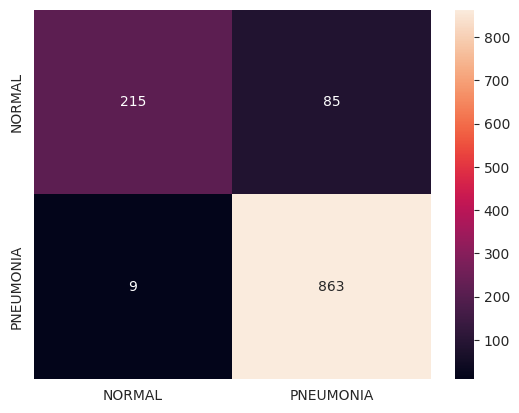

recall : 0.9896788990825688 | precision : 0.9103375527426161 | f1score : 0.9483516483516483


In [8]:
x = np.concatenate((original_datasetX, augmented_pneumonia_datasetX))
np.random.seed(random_seed)
np.random.shuffle(x)
y = np.concatenate((original_datasetY, augmented_pneumonia_datasetY))
np.random.seed(random_seed)
np.random.shuffle(y)
train_and_test_with_confusion_matrix(x, y)